In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import cmcrameri.cm as cm
import time
from skimage.data import binary_blobs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2, fftshift, ifftshift

from torchdiffeq import odeint, odeint_adjoint

from display import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim

from display import cm, format_axis, props
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [2]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [3]:
method = 'dopri5'
adjoint = False

In [4]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

### Kuramoto

In [5]:
args = {'N': 80,
        'L': 2.,
        'v': 0.5,
        'K': 0.2
       }
M = 100

kuramoto = Kuramoto(args, method, default_type)
kuramoto.init_state(M)
kuramoto.to(device)

tf = 75
T = 151
t = torch.linspace(0, tf, T)
t0 = 50
T -= t0

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

Elapsed time: 4.17 s


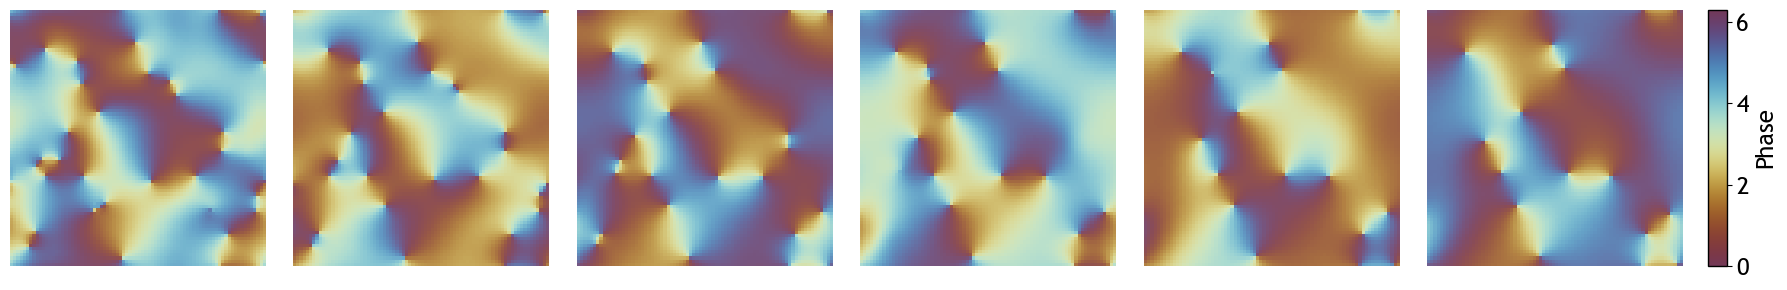

In [6]:
fig = kuramoto.plot_series(kuramoto.y[:,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Phase')

### Gray-Scott

In [ ]:
args = {'N': 200,
        'L': 2.,
        'Du': 1e-5,
        'Dv': 5e-6,
        'f': 0.040,
        'k': 0.063,
        'f0': 0.040,
        'k0': 0.060
       }
M = 100

grayscott = GrayScott(args, method, default_type)
grayscott.init_state(M)
grayscott.to(device)

tf = 2500
T = 6
t = torch.linspace(0, tf, T)

grayscott.init_solve(t)

In [ ]:
tf = 300
T = 41
t = torch.linspace(0, tf, T)

grayscott.solve(t, device=device)

In [ ]:
fig = grayscott.plot_series(grayscott.y[:,0,0].reshape(-1,grayscott.N,grayscott.N), ntype='unit', clabel='u')

### Lotka-Volterra

In [5]:
args = {'N': 400,
        'L': 2.,
        'R': 0.07,
        'alpha': 1./3,
        'beta': 2./3,
        'gamma': 0.5,
        'delta': 0.5
       }
M = 100

lv = LotkaVolterra(args, method, default_type)
lv.init_state(M)
lv.to(device)

tf = 100
T = 51
t = torch.linspace(0, tf, T)

lv.solve(t, device=device)

Elapsed time: 0.25 s


In [ ]:
fig = lv.plot_series(lv.y[:6,0], ntype='none')

### Kuramoto

In [ ]:
n = 64
f_mask = None
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):
        cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
        kuramoto.plot_frame(ax[i,j], cxs(kuramoto.y0[0], pol=1).reshape(cxs.n, cxs.n),
                            vmin=1e2, vmax=1e8, ntype='log')

In [ ]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

Detector: 64 x 64 	Probe: 1 x 1


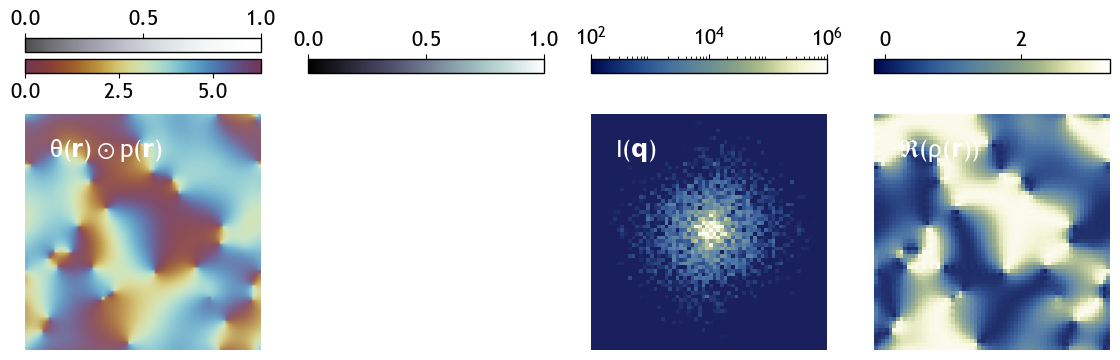

In [9]:
n = 64
dq = 1.
f_probe = None
f_mask = None
cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
cxs.shapes()
fig = cxs.plot_example(kuramoto, kuramoto.y0[0], ntype='mod', vmin=1e2, vmax=1e6)

In [ ]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

In [ ]:
fig = kuramoto.plot_series(Y_batch[:,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')

### Gray-Scott

In [ ]:
n = 64
f_mask = 0.07
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
        grayscott.plot_frame(ax[i,j], cxs(grayscott.y0[0], pol=1).reshape(cxs.n, cxs.n),
                             vmin=1e2, vmax=1e6, ntype='log')

In [ ]:
n = 64
dq = 0.8
f_probe = 0.15
f_mask = 0.07
cxs = CXSGrid(grayscott.N, n, L=grayscott.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='unit').to(device)
cxs.shapes()
fig = cxs.plot_example(grayscott, grayscott.y0[0], ntype='unit', vmin=1e2, vmax=1e6)

In [ ]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = grayscott.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch, pol=1)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

In [ ]:
fig = grayscott.plot_series(Y_batch[:,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')

### Lotka-Volterra

In [ ]:
n = 64
f_mask = 0.05
dqs = np.arange(0.7,1.05,0.1)
f_probes = np.arange(0.15,0.5,0.1)

fig, ax = plt.subplots(len(dqs), len(f_probes), figsize=(10,10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for i, dq in enumerate(dqs):
    for j, f_probe in enumerate(f_probes):     
        cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
        lv.plot_frame(ax[i,j], cxs(lv.y0[0]).reshape(cxs.n, cxs.n), vmin=1, vmax=1e4, ntype='log')

In [ ]:
n = 32
dq = 0.5
f_probe = 0.2
f_mask = 0.05
cxs = CXSPoint(lv.R, n, L=lv.L, dq=dq, f_probe=f_probe, f_mask=f_mask).to(device)
cxs.shapes()
fig = cxs.plot_example(lv, lv.y0[0], vmin=1e2, vmax=1e5)

In [ ]:
batch_time = 20
batch_size = 10
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
ti = time.time()
Y_batch = cxs(y_batch)
tf = time.time()
print('Elapsed time: {:.3f} s'.format(tf - ti))

In [ ]:
fig = lv.plot_series(Y_batch[:6,0].reshape(-1,cxs.n,cxs.n), ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')
#fig.savefig('Fig.png', dpi=200)

In [ ]:
fig = lv.plot_series(y_batch[:6,0], ntype='none')
for ax in fig._localaxes:
    cxs.plot_probe(ax)
#fig.savefig('Fig.png', dpi=200)

### Kuramoto

In [267]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'v': 0.5,
                        'K': 0.2,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, f='phase')
        
        #self.conv = nn.Conv2d(1, 1, 5, bias=False, padding='same', padding_mode='circular')
        
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, 3, bias=False, padding='same', padding_mode='circular'),
            #nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(8, 2, 3, bias=False, padding='same', padding_mode='circular'),
            #nn.Upsample(scale_factor=2, mode='bilinear')
        )
    
    def loss(self, y_true, y_pred, pol=1):
        return nn.L1Loss()(self.cxs(y_true, pol), self.cxs(y_pred, pol))
        
    '''   
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return self.v + self.K*(cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)
    '''
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        y = torch.cat([cosy, siny], dim=1) 
        return self.v + (y*self.conv(y)).sum(dim=1, keepdims=True).flatten(start_dim=-2)

In [268]:
method = 'dopri5'
adjoint = False
args = {'N': 80,
        'L': 2.,
        'v': 0.5,
        'K': 0.2,
        'n': 64,
        'dq': 1.,
        'f_probe': None,
        'f_mask': None,
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-3)
print(node)

Detector: 64 x 64 	Probe: 1 x 1
NODE(
  (cxs): CXSGrid(
    (probe): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
  )
  (conv): Sequential(
    (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
    (1): ReLU()
    (2): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
  )
)


In [282]:
max_iters = 100
chkpt = 5
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

Iteration: 0005 | Total Loss: 637.237243 | Time: 1.111329
Iteration: 0010 | Total Loss: 639.892751 | Time: 1.112065
Iteration: 0015 | Total Loss: 578.866297 | Time: 1.085176
Iteration: 0020 | Total Loss: 608.680765 | Time: 1.115226
Iteration: 0025 | Total Loss: 677.090954 | Time: 1.115729
Iteration: 0030 | Total Loss: 685.383657 | Time: 1.146940
Iteration: 0035 | Total Loss: 729.924272 | Time: 1.148018
Iteration: 0040 | Total Loss: 604.146139 | Time: 1.115468
Iteration: 0045 | Total Loss: 667.480156 | Time: 1.115438
Iteration: 0050 | Total Loss: 583.559742 | Time: 1.115489
Iteration: 0055 | Total Loss: 589.571409 | Time: 1.116048
Iteration: 0060 | Total Loss: 672.058325 | Time: 1.145917
Iteration: 0065 | Total Loss: 615.164412 | Time: 1.084283
Iteration: 0070 | Total Loss: 596.999605 | Time: 1.116330
Iteration: 0075 | Total Loss: 613.352888 | Time: 1.115364
Iteration: 0080 | Total Loss: 666.684764 | Time: 1.084817
Iteration: 0085 | Total Loss: 626.865232 | Time: 1.115841
Iteration: 009

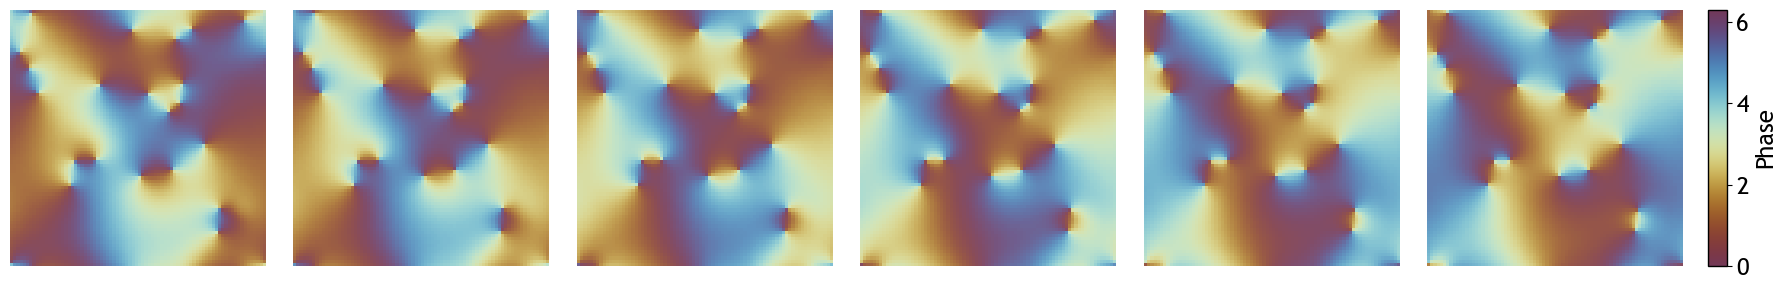

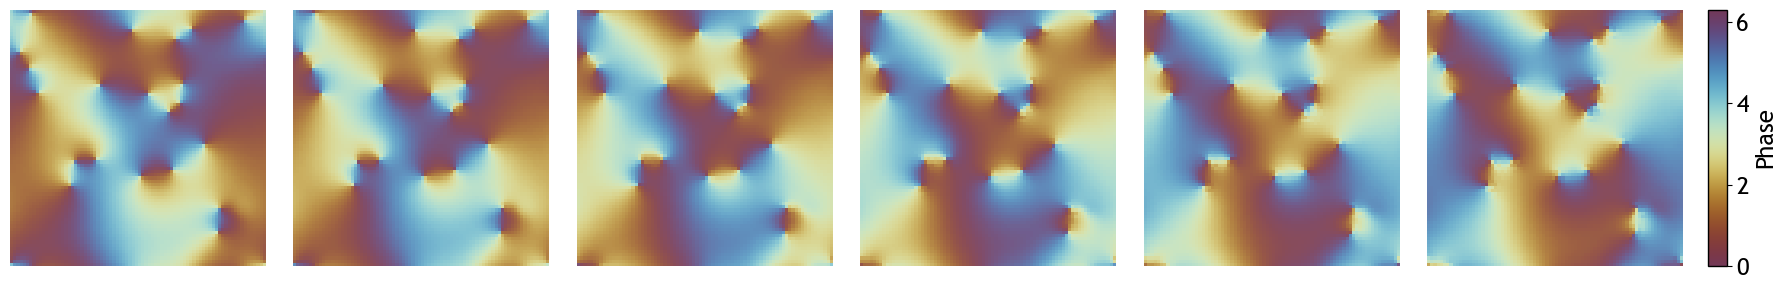

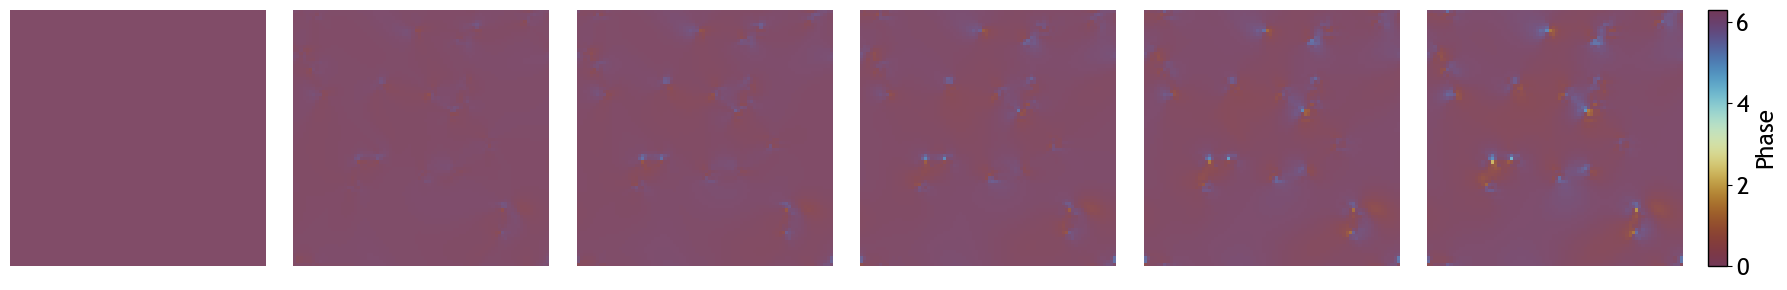

In [283]:
t_batch, y0_batch, y_batch = kuramoto.get_batch(3*batch_time, 1)
y_pred = node.solve(t_batch, y0_batch, device)

fig = node.plot_series(y_batch[:batch_time,0].detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')
#fig.savefig('Fig1.png', dpi=400, bbox_inches='tight')
fig = node.plot_series(y_pred[:batch_time,0].detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')
#fig.savefig('Fig2.png', dpi=400, bbox_inches='tight')

diff = y_pred[:batch_time,0] - y_batch[:batch_time,0]
fig = node.plot_series(diff.detach().reshape(-1,node.N,node.N), ntype='mod', clabel='Phase')
#fig.savefig('Fig3.png', dpi=400, bbox_inches='tight')

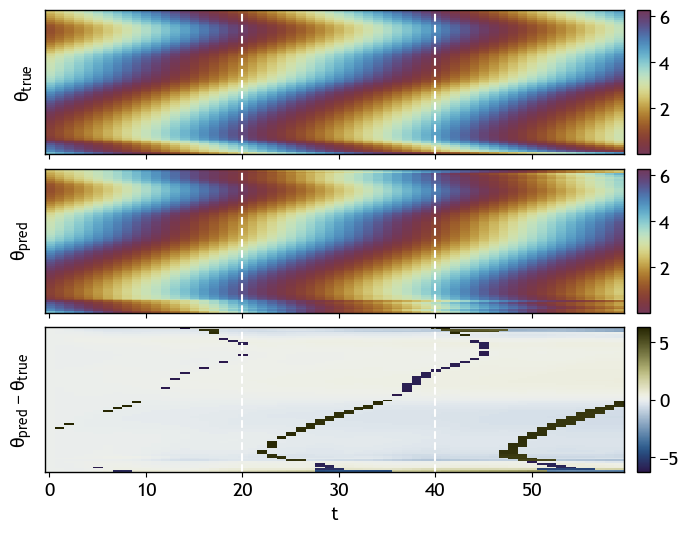

In [284]:
fig, ax = plt.subplots(3,1, figsize=(9,6), sharex=True)
sm = []
sm.append(ax[0].imshow(np.mod(y_batch[:,0].reshape(-1,node.N,node.N)[:,0].detach().cpu(), 2*np.pi).T, aspect='auto',
          origin='lower', cmap=cm.romaO, interpolation='none'))
sm.append(ax[1].imshow(np.mod(y_pred[:,0].reshape(-1,node.N,node.N)[:,0].detach().cpu(), 2*np.pi).T, aspect='auto',
          origin='lower', cmap=cm.romaO, interpolation='none'))
y_diff = np.mod(y_pred[:,0].reshape(-1,node.N,node.N)[:,0].detach().cpu(), 2*np.pi).T - \
         np.mod(y_batch[:,0].reshape(-1,node.N,node.N)[:,0].detach().cpu(), 2*np.pi).T
vmax = y_diff.abs().max()
sm.append(ax[2].imshow(y_diff, aspect='auto', origin='lower', cmap=cm.broc, interpolation='none',
                       vmin=-vmax, vmax=vmax))

ax[0].axvline(batch_time, color='white', ls='dashed')
ax[1].axvline(batch_time, color='white', ls='dashed')
ax[2].axvline(batch_time, color='white', ls='dashed')

ax[0].axvline(2*batch_time, color='white', ls='dashed')
ax[1].axvline(2*batch_time, color='white', ls='dashed')
ax[2].axvline(2*batch_time, color='white', ls='dashed')

ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
tprops = props.copy()
tprops.set_size(14)
format_axis(ax[0], tprops, xlabel='', ylabel=r'$\theta_{true}$')
format_axis(ax[1], tprops, xlabel='', ylabel=r'$\theta_{pred}$')
format_axis(ax[2], tprops, xlabel='t', ylabel=r'$\theta_{pred}-\theta_{true}$')
for i in range(len(sm)):
    cbar = plt.colorbar(sm[i], ax=ax[i], aspect=12, pad=0.02)
    format_axis(cbar.ax, tprops)
fig.subplots_adjust(hspace=0.1)

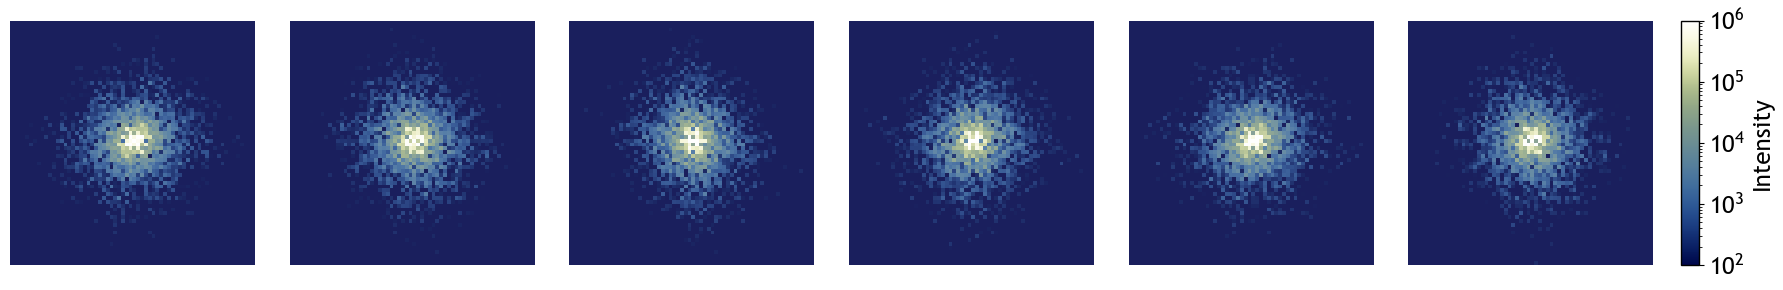

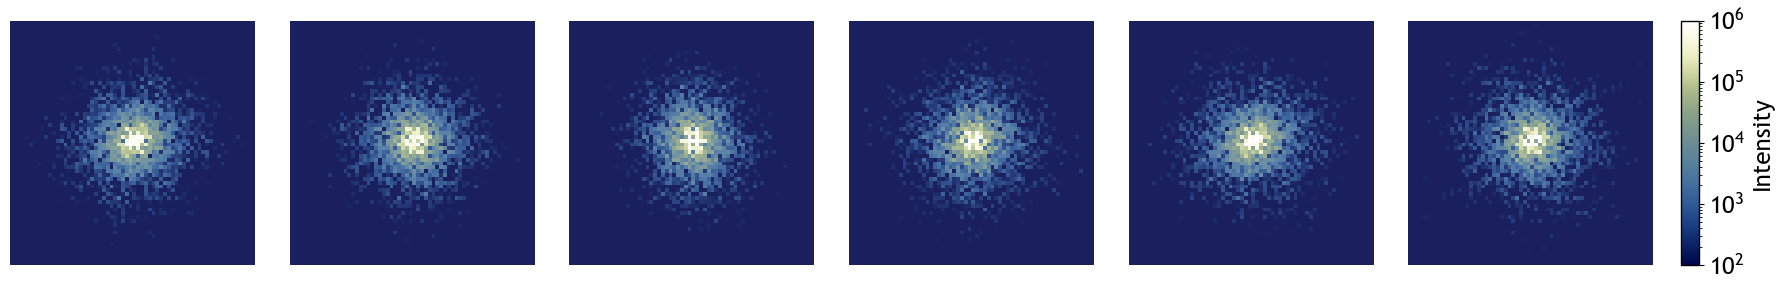

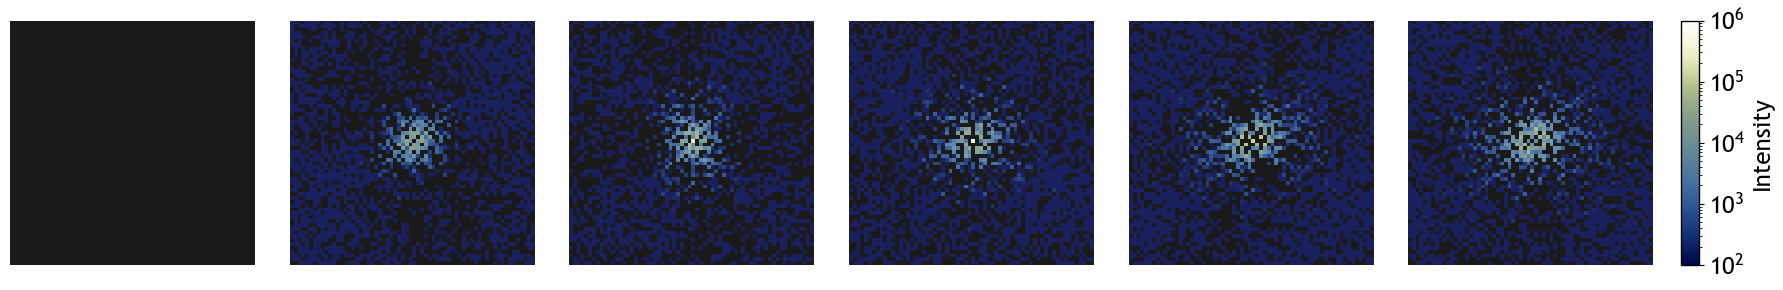

In [285]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:batch_time,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:batch_time,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')
    
    diff = node.cxs(y_pred[:batch_time,0]) - node.cxs(y_batch[:batch_time,0])
    fig = node.plot_series(diff.reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')

In [ ]:
#fig.savefig('Fig.png', dpi=400, bbox_inches='tight')

In [314]:
def smooth_cutoff(x, r=1):
    def h(y):
        return (y >= 0)*torch.exp(-r/y)
    return h(x)/(h(x) + h(r-x))

In [347]:
x = torch.arange(kuramoto.N, dtype=default_type) - kuramoto.N/2.
y = torch.arange(kuramoto.N, dtype=default_type) - kuramoto.N/2.
X, Y = torch.meshgrid(x, y, indexing='xy')
mask = 1 - smooth_cutoff(torch.sqrt(X**2 + Y**2), r=0.8*kuramoto.N)
y = torch.atan2(Y,X)

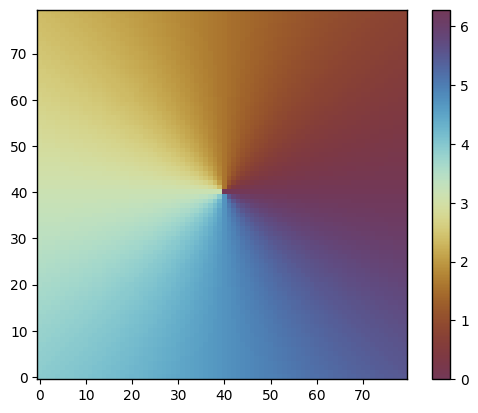

In [348]:
plt.imshow(np.mod(y, 2*np.pi), origin='lower', vmin=0, vmax=2*np.pi, cmap=cm.romaO)
plt.colorbar()

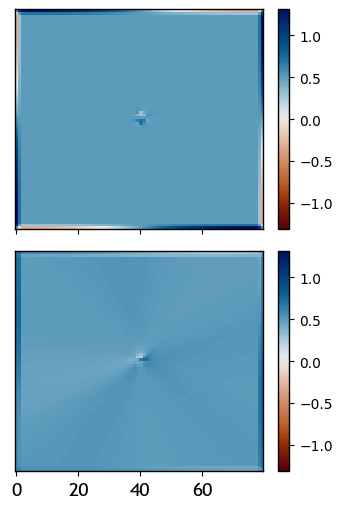

In [349]:
fig, ax = plt.subplots(2,1, figsize=(4,6), sharex=True)
y_true = kuramoto(torch.tensor(0), y.view(1,1,-1).to(device)).reshape(node.N,node.N).detach().cpu()
y_pred = node(torch.tensor(0), y.view(1,1,-1).to(device)).reshape(node.N,node.N).detach().cpu()
vmax = y_true.abs().max()

g0 = ax[0].imshow(y_true, aspect='auto', origin='lower', vmin=-vmax, vmax=vmax, cmap=cm.vik_r, interpolation='none')
g1 = ax[1].imshow(y_pred, aspect='auto', origin='lower', vmin=-vmax, vmax=vmax, cmap=cm.vik_r, interpolation='none')

ax[0].set_yticks([])
ax[1].set_yticks([])
tprops = props.copy()
tprops.set_size(14)
format_axis(ax[1], tprops)
plt.colorbar(g0, ax=ax[0])
plt.colorbar(g1, ax=ax[1])
fig.subplots_adjust(hspace=0.1)

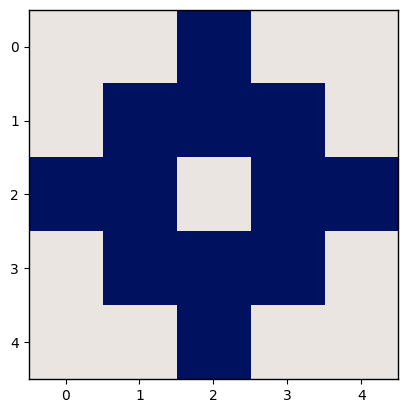

In [225]:
plt.imshow(kuramoto.conv.weight.detach().squeeze().cpu(), vmin=-1, vmax=1, cmap=cm.vik_r)

In [56]:
node.conv

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
  (4): Upsample(scale_factor=2.0, mode=nearest)
)

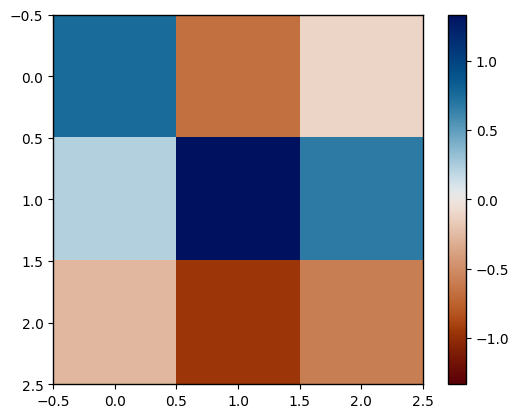

In [58]:
w = node.conv[0].weight.detach().cpu().sum(dim=(0,1))
vmax = w.abs().max()
plt.imshow(w, vmin=-vmax, vmax=vmax, cmap=cm.vik_r)
plt.colorbar()

### Gray-Scott

In [ ]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [ ]:
import torch.nn.functional as F
import torch.nn.utils.parametrize as P

class UnitConv2d(nn.Conv2d):
    def forward(self, input):
        return F.conv2d(input, self.weight - self.weight.mean(), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class Conserved(nn.Module):
    def forward(self, input):
        return input - input.mean()
    
    
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask, f='unit')
        
        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2),
        )
        
        self.init_weights(self.F, std=0.01)
                
        self.conv = nn.Conv2d(1, 1, 3, bias=False, padding='same', padding_mode='circular')
        #P.register_parametrization(self.conv, "weight", Conserved())
        #self.conv = UnitConv2d(1, 1, 3, bias=False, padding='same', padding_mode='circular')
        # TO DO: register parameterization with symmetry or summation of 1
        self.conv.weight = nn.Parameter(torch.tensor([[[[0,0.1,0],
                                                        [0.1,-0.4,0.1],
                                                        [0,0.1,0]]]], dtype=default_type), requires_grad=True)
        P.register_parametrization(self.conv, "weight", Conserved())
    
    def init_weights(self, x, std=0.01):
        for p in x.parameters():
            if p.ndim > 1:
                nn.init.normal_(p, mean=0, std=std)
            else:
                nn.init.uniform_(p, -std, std)
                
                
    def loss(self, y_true, y_pred, pol=1, lam=0.1):
        x_true = self.cxs(y_true, pol)
        x_pred = self.cxs(y_pred, pol)
        return nn.L1Loss()(x_true/x_true.max(), x_pred/x_pred.max()) + lam*torch.abs(y_true).mean()
    
    
    def forward(self, t, y):
        u, v = y.view((-1, 2, self.N, self.N)).split([1,1], dim=1)
        du = self.conv(u)
        dv = self.conv(v)
        dy = torch.cat([du, dv], dim=1).flatten(start_dim=-2)
        #dy += self.F(y.transpose(-1,-2)).transpose(-1,-2)
        return dy

In [ ]:
method = 'dopri5'
adjoint = True
args = {'N': 200,
        'L': 2.,
        'n': 64,
        'dq': 0.8,
        'f_probe': 0.15,
        'f_mask': 0.07,
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-3)
print(node)

In [ ]:
node.conv.weight

In [ ]:
(node.conv.weight - node.conv.weight.mean()).sum()

In [ ]:
max_iters = 50
chkpt = 1
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = grayscott.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred, lam=0.1)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

In [ ]:
i = 0
with torch.no_grad():
    t_batch, y0_batch, y_batch = grayscott.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    
    fig = node.plot_series(y_batch[:,0,i].detach().reshape(-1,node.N,node.N), ntype='unit', clabel=['u','v'][i])
    fig = node.plot_series(y_pred[:,0,i].detach().reshape(-1,node.N,node.N), ntype='unit', clabel=['u','v'][i])

    diff = y_pred[:,0,i] - y_batch[:,0,i]
    fig = node.plot_series(diff.detach().reshape(-1,node.N,node.N), ntype='unit', clabel=['u','v'][i])

In [ ]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e6, clabel='Intensity')

In [ ]:
fig = node.cxs.plot_example(node, y_pred[5*(batch_time//6),0].detach(), vmin=1e2, vmax=1e6)

### Lotka-Volterra

In [ ]:
import sys, importlib
importlib.reload(sys.modules['cxs'])
importlib.reload(sys.modules['ode'])
from ode import ODE, Kuramoto, GrayScott, LotkaVolterra
from cxs import CXSGrid, CXSPoint

In [ ]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True)
        
        default_args = {'L': 2.,
                        'R': 0.05,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        self.cxs = CXSPoint(self.R, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask)
        
        #self.A = nn.Linear(2,2)

        self.F = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )
                
    
    def loss(self, y_true, y_pred):
        return nn.L1Loss()(self.cxs(y_true), self.cxs(y_pred))
        
        
    def forward(self, t, y):
        N = y.shape[-2]
        y_mean = y.mean(dim=-2, keepdims=True)
        dy = self.F(y_mean) #+self.A(y_mean)
        return torch.tile(dy, (1, N, 1))

In [ ]:
method = 'dopri5'
adjoint = False
args = {'L': 2.,
        'R': 0.07,
        'n': 32,
        'dq': 0.5,
        'f_probe': 0.2,
        'f_mask': 0.05,
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=1e-2)
print(node)

In [ ]:
t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
print(torch.cat((lv(t_batch, y_batch)[:,3,0], node(t_batch, y_batch)[:,3,0]), dim=-1))

In [ ]:
max_iters = 100
chkpt = 5
batch_time = 20
batch_size = 10

end = time.time()
loss = []
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_batch, y_pred)
    
    _loss.backward()
    optimizer.step()

    if k % chkpt == 0:
        with torch.no_grad():
            loss.append(_loss.item())
            print('Iteration: {:04d} | Total Loss: {:.6f} | Time: {:.6f}'.format(k, _loss.item(), time.time() - end))

    end = time.time()

In [ ]:
with torch.no_grad():
    t_batch, y0_batch, y_batch = lv.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    fig = node.plot_series([y_batch[:,0], y_pred[:,0].detach()], ntype='none')

In [ ]:
with torch.no_grad():
    fig = node.plot_series(node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')
    fig = node.plot_series(node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')
    
    diff = node.cxs(y_pred[:,0]) - node.cxs(y_batch[:,0])
    fig = node.plot_series(diff.reshape(-1,node.cxs.n,node.cxs.n),
                           ntype='log', vmin=1e2, vmax=1e5, clabel='Intensity')

In [ ]:
fig = node.cxs.plot_example(node, y_pred[5*(batch_time//6),0].detach(), vmin=1e2, vmax=1e5)